In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torchsummary
from torchsummary import summary
from tqdm import tqdm

### For Reproducablity

In [0]:
SEED = 1

#If cuda is available

use_cuda = torch.cuda.is_available()
# For reproducibility
torch.manual_seed(SEED)

if use_cuda:
    torch.cuda.manual_seed(SEED)

### Select the device to use

In [3]:

device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


### Data Transformations
We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [0]:
torch.manual_seed(1)
batch_size = 128


# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=8, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True, transform=train_transforms),
                                            **dataloader_args)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, download=True, transform=test_transforms),
                                          **dataloader_args)

### Define the Model

In [0]:
dropout_value = 0.2

OP_CH_CONV_BLK1  = 16
OP_CH_CONV_BLK2  = 12
OP_CH_CONV_BLK21 = 32
OP_CH_CONV_BLK3  = 12
OP_CH_CONV_BLK4  = 12
OP_CH_CONV_BLK5  = 12
OP_CH_CONV_BLK6  = 12
OP_CH_CONV_BLK7  = 12
OP_CH_CONV_BLK71 = 32
OP_NODES = 10


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=OP_CH_CONV_BLK1, kernel_size=(3, 3), padding=0, bias=False),
                                        nn.ReLU(),
                                        nn.Dropout(dropout_value),
                                        nn.BatchNorm2d(OP_CH_CONV_BLK1)
                                        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(nn.Conv2d(in_channels=OP_CH_CONV_BLK1, out_channels=OP_CH_CONV_BLK2, kernel_size=(3, 3), padding=0, bias=False),
                                        nn.ReLU(),
                                        nn.Dropout(dropout_value),
                                        nn.BatchNorm2d(OP_CH_CONV_BLK2)
                                        ) # output_size = 24


        self.convblock21 = nn.Sequential(
                                        nn.Conv2d(in_channels=OP_CH_CONV_BLK2, out_channels=OP_CH_CONV_BLK21, kernel_size=(1, 1), padding=0, bias=False),
                                        nn.ReLU(),
                                        nn.Dropout(dropout_value),
                                        nn.BatchNorm2d(OP_CH_CONV_BLK21)
                                        ) # output_size = 22
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        self.convblock3 = nn.Sequential(
                                        nn.Conv2d(in_channels=OP_CH_CONV_BLK21, out_channels=OP_CH_CONV_BLK3, kernel_size=(3, 3), padding=0, bias=False),
                                        nn.ReLU(),
                                        nn.Dropout(dropout_value),
                                        nn.BatchNorm2d(OP_CH_CONV_BLK3)
                                        ) # output_size = 10


        self.convblock4 = nn.Sequential(
                                        nn.Conv2d(in_channels=OP_CH_CONV_BLK3, out_channels=OP_CH_CONV_BLK4, kernel_size=(1, 1), padding=0, bias=False),
                                        nn.ReLU(),
                                        nn.Dropout(dropout_value),
                                        nn.BatchNorm2d(OP_CH_CONV_BLK4)
                                        ) # output_size = 8


        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
                                        nn.Conv2d(in_channels=OP_CH_CONV_BLK4, out_channels=OP_CH_CONV_BLK5, kernel_size=(3, 3), padding=0, bias=False),
                                        nn.ReLU(),
                                        nn.Dropout(dropout_value),
                                        nn.BatchNorm2d(OP_CH_CONV_BLK5)
                                        ) # output_size = 6

        self.convblock6 = nn.Sequential(
                                        nn.Conv2d(in_channels=OP_CH_CONV_BLK5, out_channels=OP_CH_CONV_BLK6, kernel_size=(3, 3), padding=0, bias=False),
                                        nn.ReLU(),
                                        nn.Dropout(dropout_value),
                                        nn.BatchNorm2d(OP_CH_CONV_BLK6)
                                        ) # output_size = 4

        self.convblock7 = nn.Sequential(
                                          nn.Conv2d(in_channels=OP_CH_CONV_BLK6, out_channels=OP_CH_CONV_BLK7, kernel_size=(3, 3), padding=0, bias=False),
                                          nn.ReLU(),
                                          nn.Dropout(dropout_value),
                                          nn.BatchNorm2d(OP_CH_CONV_BLK7)
                                          ) # output_size = 2

        self.convblock71 = nn.Sequential(
                                          nn.Conv2d(in_channels=OP_CH_CONV_BLK7, out_channels=OP_CH_CONV_BLK71, kernel_size=(1, 1), padding=0, bias=False),
                                          nn.ReLU(),
                                          nn.Dropout(dropout_value),
                                          nn.BatchNorm2d(OP_CH_CONV_BLK71)
                                          ) # output_size = 2
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
                                  nn.AvgPool2d(kernel_size=4),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(OP_CH_CONV_BLK71),
                                  #nn.Dropout(dropout_value)
                                  ) # output_size = 1

        self.convblock8 = nn.Sequential(
                                        nn.Conv2d(in_channels=OP_CH_CONV_BLK71, out_channels=OP_NODES, kernel_size=(1, 1), padding=0, bias=False),
                                        # nn.BatchNorm2d(10), NEVER
                                        # nn.ReLU() NEVER!
                                        ) # output_size = 1


    def forward(self, x):
        x = self.convblock1(x)# 26x26
        x = self.convblock2(x)# 24x24
        x = self.convblock21(x)# 24x24
        x = self.pool1(x) # 12x12
        x = self.convblock3(x)# 10x10
        x = self.convblock4(x) # 8x8
        x = self.convblock5(x) # 6x6
        x = self.convblock6(x) # 4x4
        x = self.convblock7(x) # 2x2
        x = self.convblock71(x) # 2x2
        x = self.gap(x)
        x = self.convblock8(x) #1x1
        x = x.view(-1, OP_NODES)
        return F.log_softmax(x, dim=-1)

#### Model *Summary*

In [10]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
           Dropout-3           [-1, 16, 26, 26]               0
       BatchNorm2d-4           [-1, 16, 26, 26]              32
            Conv2d-5           [-1, 12, 24, 24]           1,728
              ReLU-6           [-1, 12, 24, 24]               0
           Dropout-7           [-1, 12, 24, 24]               0
       BatchNorm2d-8           [-1, 12, 24, 24]              24
            Conv2d-9           [-1, 32, 24, 24]             384
             ReLU-10           [-1, 32, 24, 24]               0
          Dropout-11           [-1, 32, 24, 24]               0
      BatchNorm2d-12           [-1, 32, 24, 24]              64
        MaxPool2d-13           [-1, 32, 12, 12]               0
           Conv2d-14           [-1, 12,

##### Deifine the loss functin and the optimizer

##### Define the test and train function

In [0]:
def train(model,
          train_loader,
          optimizer,
          loss_function,
          device,
          current_epoch,
          loss_array,
          acc_array):
  
    print("Started Epoch {}....\n".format(current_epoch+1))
    #set model to train
    model.train()
    pbar = tqdm(train_loader)

    correct = 0
    processed = 0

    #loop over the batches of the train loader
    for batch_idx, (data, target) in enumerate(pbar):
        #move the data to the selected device
        data, target = data.to(device), target.to(device)
        #set the optimizer to zero gradients
        optimizer.zero_grad()
        #pass the input to the model
        y_pred = model(data)
        #print('1:',y_pred.shape, target.shape)
        #caluclate the loss
        loss = loss_function(y_pred, target)
        #print('2:')
        #backpropagate
        loss.backward()
        #optimize
        optimizer.step()
        #print the losses
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        
        #collect the loss and accuracy data
        loss_array.append(loss)
        acc_array.append(100.0*correct/processed)


def test(model,
          test_loader,
          loss_function,
          device,
          loss_array,
          acc_array):
  
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_function(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    loss_array.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                                                                                test_loss, correct, len(test_loader.dataset),
                                                                                100. * correct / len(test_loader.dataset)))
    
    acc_array.append(100. * correct / len(test_loader.dataset))

### Let's Train and test our model

#### Deifine the 
  - loss functin
  - optimizer

In [0]:
model =  Net().to(device)

loss_function = F.nll_loss
#loss_function = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [22]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

EPOCHS = 12

for epoch in range(EPOCHS):
    train(model, train_loader, optimizer, loss_function, device, epoch, train_losses, train_acc)
    test(model, test_loader, loss_function, device, test_losses, test_acc)

  0%|          | 0/469 [00:00<?, ?it/s]

Started Epoch 1....



Loss=0.07240008562803268 Batch_id=468 Accuracy=89.05: 100%|██████████| 469/469 [00:14<00:00, 32.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0924, Accuracy: 9733/10000 (97%)

Started Epoch 2....



Loss=0.04955221340060234 Batch_id=468 Accuracy=96.56: 100%|██████████| 469/469 [00:14<00:00, 32.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0563, Accuracy: 9832/10000 (98%)

Started Epoch 3....



Loss=0.046720411628484726 Batch_id=468 Accuracy=97.32: 100%|██████████| 469/469 [00:14<00:00, 32.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9865/10000 (99%)

Started Epoch 4....



Loss=0.03865278139710426 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:14<00:00, 32.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 9861/10000 (99%)

Started Epoch 5....



Loss=0.07221149653196335 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:14<00:00, 32.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 9885/10000 (99%)

Started Epoch 6....



Loss=0.043104544281959534 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:14<00:00, 32.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 9898/10000 (99%)

Started Epoch 7....



Loss=0.062177713960409164 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:14<00:00, 32.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0353, Accuracy: 9887/10000 (99%)

Started Epoch 8....



Loss=0.06845096498727798 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:14<00:00, 32.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9902/10000 (99%)

Started Epoch 9....



Loss=0.07344513386487961 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:14<00:00, 32.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9909/10000 (99%)

Started Epoch 10....



Loss=0.031118547543883324 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:14<00:00, 32.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9895/10000 (99%)

Started Epoch 11....



Loss=0.007821847684681416 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:14<00:00, 32.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9910/10000 (99%)

Started Epoch 12....



Loss=0.04811506345868111 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:14<00:00, 32.60it/s]



Test set: Average loss: 0.0308, Accuracy: 9904/10000 (99%)



Text(0.5, 1.0, 'Test Accuracy')

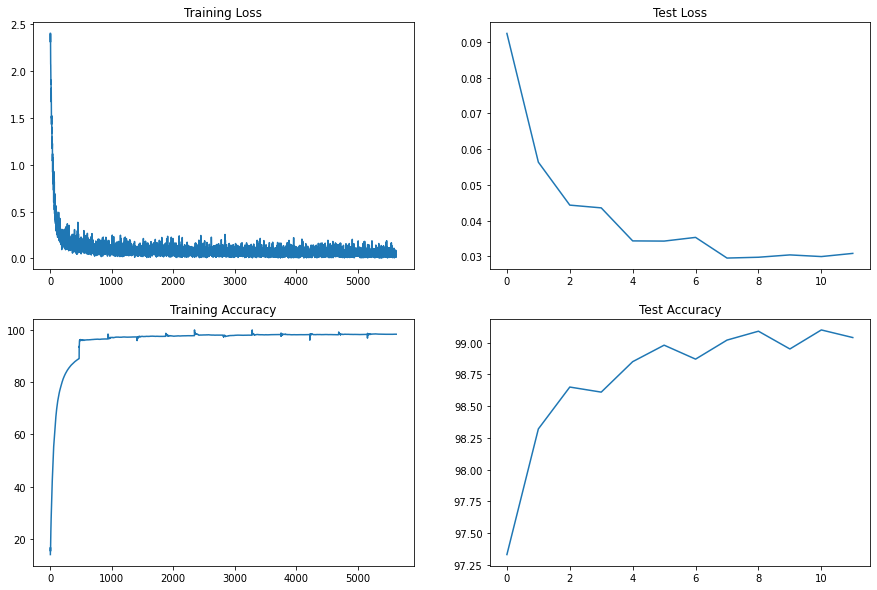

In [24]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:
dropout_value = 0.1
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=13, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(13)
            
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=13, out_channels=13, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(13)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=13, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(12)
        ) # output_size = 22

        self.convblock31 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(12)
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(12)
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(12)
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(12)
        ) # output_size = 7

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(12)
        ) # output_size = 7

        self.convblock71 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(20)
        ) # output_size = 7

        self.convblock72 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=48, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(48)
        ) # output_size = 7

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5),
            nn.ReLU(),
            nn.BatchNorm2d(48),
            #nn.Dropout(dropout_value)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1


    def forward(self, x):
        x = self.convblock1(x)# 26x26
        x = self.convblock2(x)# 24x24
        x = self.convblock3(x)# 22x22
        x = self.convblock31(x)# 22x22
        x = self.pool1(x) # 11x11

        
        x = self.convblock4(x) # 11x11
        x = self.convblock5(x) # 9x9
        x = self.convblock6(x) # 7x7
        x = self.convblock7(x) # 7x7
        x = self.convblock71(x) # 5x5
        x = self.convblock72(x) # 5x5
        x = self.gap(x)
        x = self.convblock8(x) #1x1
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [0]:
model1 =  Net1().to(device)


loss_function = F.nll_loss
#loss_function = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)


EPOCHS = 12

In [29]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []


for epoch in range(EPOCHS):
    train(model1, train_loader, optimizer, loss_function, device, epoch, train_losses, train_acc)
    test(model1, test_loader, loss_function, device, test_losses, test_acc)

  0%|          | 0/469 [00:00<?, ?it/s]

Started Epoch 1....



Loss=0.18022233247756958 Batch_id=468 Accuracy=87.39: 100%|██████████| 469/469 [00:14<00:00, 31.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0889, Accuracy: 9721/10000 (97%)

Started Epoch 2....



Loss=0.13723701238632202 Batch_id=468 Accuracy=96.07: 100%|██████████| 469/469 [00:14<00:00, 31.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0573, Accuracy: 9828/10000 (98%)

Started Epoch 3....



Loss=0.13304366171360016 Batch_id=468 Accuracy=96.78: 100%|██████████| 469/469 [00:14<00:00, 31.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0543, Accuracy: 9830/10000 (98%)

Started Epoch 4....



Loss=0.029128441587090492 Batch_id=468 Accuracy=97.06: 100%|██████████| 469/469 [00:14<00:00, 32.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0491, Accuracy: 9847/10000 (98%)

Started Epoch 5....



Loss=0.09658411145210266 Batch_id=468 Accuracy=97.32: 100%|██████████| 469/469 [00:14<00:00, 31.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0428, Accuracy: 9872/10000 (99%)

Started Epoch 6....



Loss=0.06465945392847061 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:14<00:00, 31.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0431, Accuracy: 9883/10000 (99%)

Started Epoch 7....



Loss=0.019564112648367882 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:14<00:00, 31.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0456, Accuracy: 9868/10000 (99%)

Started Epoch 8....



Loss=0.09514179825782776 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:14<00:00, 31.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9887/10000 (99%)

Started Epoch 9....



Loss=0.09443650394678116 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:14<00:00, 31.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0434, Accuracy: 9868/10000 (99%)

Started Epoch 10....



Loss=0.047059983015060425 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:14<00:00, 31.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9908/10000 (99%)

Started Epoch 11....



Loss=0.05045679211616516 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:14<00:00, 31.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0395, Accuracy: 9886/10000 (99%)

Started Epoch 12....



Loss=0.0982556939125061 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:14<00:00, 31.30it/s]



Test set: Average loss: 0.0395, Accuracy: 9875/10000 (99%)



Text(0.5, 1.0, 'Test Accuracy')

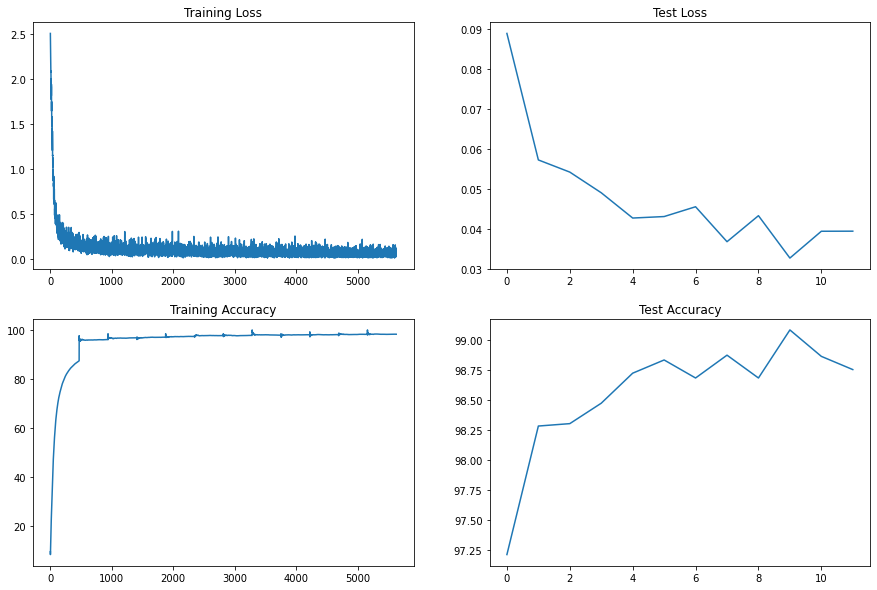

In [30]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")